In [423]:
# Import required dependencies
import boto3
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
from io import StringIO
import os

# Allow pandas to display all columns from a dataframe
pd.options.display.max_columns = None

In [424]:
bucket_name = 'finance-factoring-ml-dev'

# Import Products
df = pd.read_csv(
    's3://{}/data/formatted_dataset.csv'.format(bucket_name), 
    sep=',', 
    parse_dates=['credito_fecha_inicio', 'credito_fecha_fin', 'fecha_pago', 'cliente_fecha_nacimiento']
)
df.head()

,folio_factura,folio_credito,factura_importe,factura_moneda,credito_fecha_inicio,credito_fecha_fin,fecha_pago,dias_financiar,aplica_interes_en_dispersion,porcentaje_adelanto,linea_tipo,contrato_marco,linea_limite,linea_moneda_principal,linea_monedas_permitidas,cliente_rfc,cliente_razon_social,cliente_regimen_fiscal,cliente_pais,cliente_fecha_nacimiento,cliente_ocupacion,cliente_sector,codigo_scian,codigo_scian_nombre,riesgo_pld,pagador_rfc,pagador_nombre,pagador_pais,pagador_scian,pagador_scian_nombre
0,5212,ACF2021021-4*1,6905230.58,MXN,2022-07-01,2022-11-18,2022-07-18,140,False,90.0,Blú Index,ACF2021021,20000000.0,MXN,"[""MXN"", ""USD""]",IMO621228BP3,INDUSTRIAS MONTILLA SA DE CV,PM,MEX,1962-12-28,FABRICACION DE ESTRUCTURAS DE METAL,Privado,332999.0,Fabricación de otros productos metálicos,BAJO,GMM3612284D0,GENERAL MOTORS DE MEXICO S DE RL DE CV,MEX,336110.0,Fabricación de automóviles y camionetas
1,R5588,ACF2021033*1,5486110.96,MXN,2021-12-30,2022-03-04,2022-02-28,64,True,85.0,Blú Index,ACF2021033,375000.0,USD,"[""MXN"", ""USD""]",PIH1202082T2,PROVEEDORA INDUSTRIAL DE HERRAMIENTAS Y LUBRIC...,PM,MEX,2012-02-08,FABRICACION DE REFACCIONES Y MAQUINARIA INDUST...,Privado,811312.0,Reparación y mantenimiento de maquinaria y equ...,BAJO,EME8409145T2,"EMERMEX, S.A. DE C.V.",NaN,NaN,NaN
2,5477,ACF2021021-5,5464161.79,MXN,2022-11-25,2023-04-21,2022-12-23,147,True,90.0,Blú Index,ACF2021021,20000000.0,MXN,"[""MXN"", ""USD""]",IMO621228BP3,INDUSTRIAS MONTILLA SA DE CV,PM,MEX,1962-12-28,FABRICACION DE ESTRUCTURAS DE METAL,Privado,332999.0,Fabricación de otros productos metálicos,BAJO,CMZ840522T3A,LAS CERVEZAS MODELO EN ZACATECAS,MEX,431213.0,Comercio al por mayor de cerveza
3,1603,ACF2022040-54,5286577.84,MXN,2022-12-22,2023-01-20,2023-01-06,29,True,85.0,Blú Index,ACF2022040,9000000.0,MXN,"[""MXN"", ""USD""]",GCL1212214H3,GRUPO CONSTRUCTOR LERAVI SA DE CV,PM,MEX,2012-12-21,CONSTRUCCION DE ESTADIOS MONUMENTOS Y OTRAS OB...,Privado,237999.0,Otras construcciones de ingeniería civil,BAJO,MCA900621K92,BUENA VISTA DEL COBRE SA DE CV,MEX,212231.0,Minería de cobre
4,5121,ACF2021021-1*1,5198617.84,MXN,2022-03-25,2022-09-27,2022-05-06,186,True,90.0,Blú Index,ACF2021021,20000000.0,MXN,"[""MXN"", ""USD""]",IMO621228BP3,INDUSTRIAS MONTILLA SA DE CV,PM,MEX,1962-12-28,FABRICACION DE ESTRUCTURAS DE METAL,Privado,332999.0,Fabricación de otros productos metálicos,BAJO,GMM3612284D0,GENERAL MOTORS DE MEXICO S DE RL DE CV,MEX,336110.0,Fabricación de automóviles y camionetas


In [425]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24010 entries, 0 to 24009
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   folio_factura                 24006 non-null  object        
 1   folio_credito                 24010 non-null  object        
 2   factura_importe               24010 non-null  float64       
 3   factura_moneda                24010 non-null  object        
 4   credito_fecha_inicio          24010 non-null  datetime64[ns]
 5   credito_fecha_fin             24010 non-null  datetime64[ns]
 6   fecha_pago                    24003 non-null  datetime64[ns]
 7   dias_financiar                24010 non-null  int64         
 8   aplica_interes_en_dispersion  24010 non-null  bool          
 9   porcentaje_adelanto           24010 non-null  float64       
 10  linea_tipo                    24010 non-null  object        
 11  contrato_marco              

# 1- Select Data

## 1.1 Remove duplicates

In [427]:
df_copy = df.copy()
df_copy.sort_values("folio_factura", inplace = True)

unique_columns = ['folio_factura', 'folio_credito']
duplicates = df_copy.duplicated(subset=unique_columns)
print('Number of duplicate records:', duplicates.sum())

# Extract duplicated rows
df_copy.loc[duplicates, :]

Number of duplicate records: 0


,folio_factura,folio_credito,factura_importe,factura_moneda,credito_fecha_inicio,credito_fecha_fin,fecha_pago,dias_financiar,aplica_interes_en_dispersion,porcentaje_adelanto,linea_tipo,contrato_marco,linea_limite,linea_moneda_principal,linea_monedas_permitidas,cliente_rfc,cliente_razon_social,cliente_regimen_fiscal,cliente_pais,cliente_fecha_nacimiento,cliente_ocupacion,cliente_sector,codigo_scian,codigo_scian_nombre,riesgo_pld,pagador_rfc,pagador_nombre,pagador_pais,pagador_scian,pagador_scian_nombre


In [428]:
# Remove unnecesary columns
df.drop([
    "folio_factura", "folio_credito", "factura_moneda", "dias_financiar", "aplica_interes_en_dispersion", "porcentaje_adelanto", "linea_tipo", "contrato_marco",
    "linea_moneda_principal", "linea_monedas_permitidas", 
    "cliente_rfc", "cliente_razon_social", "cliente_pais", "codigo_scian", "codigo_scian_nombre", "riesgo_pld",
    "pagador_nombre", "pagador_pais", "pagador_scian"
], axis=1, inplace=True)

df.head()

,factura_importe,credito_fecha_inicio,credito_fecha_fin,fecha_pago,linea_limite,cliente_regimen_fiscal,cliente_fecha_nacimiento,cliente_ocupacion,cliente_sector,pagador_rfc,pagador_scian_nombre
0,6905230.58,2022-07-01,2022-11-18,2022-07-18,20000000.0,PM,1962-12-28,FABRICACION DE ESTRUCTURAS DE METAL,Privado,GMM3612284D0,Fabricación de automóviles y camionetas
1,5486110.96,2021-12-30,2022-03-04,2022-02-28,375000.0,PM,2012-02-08,FABRICACION DE REFACCIONES Y MAQUINARIA INDUST...,Privado,EME8409145T2,NaN
2,5464161.79,2022-11-25,2023-04-21,2022-12-23,20000000.0,PM,1962-12-28,FABRICACION DE ESTRUCTURAS DE METAL,Privado,CMZ840522T3A,Comercio al por mayor de cerveza
3,5286577.84,2022-12-22,2023-01-20,2023-01-06,9000000.0,PM,2012-12-21,CONSTRUCCION DE ESTADIOS MONUMENTOS Y OTRAS OB...,Privado,MCA900621K92,Minería de cobre
4,5198617.84,2022-03-25,2022-09-27,2022-05-06,20000000.0,PM,1962-12-28,FABRICACION DE ESTRUCTURAS DE METAL,Privado,GMM3612284D0,Fabricación de automóviles y camionetas


In [429]:
df.shape

(24010, 11)

# 2- Clean Data

## 2.1 Formating columns

In [430]:
df = df.astype({
    'cliente_regimen_fiscal': str,
    'cliente_ocupacion': str,    
    'cliente_sector': str,
    'pagador_rfc': str,
    'pagador_scian_nombre': str,
})

In [431]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24010 entries, 0 to 24009
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   factura_importe           24010 non-null  float64       
 1   credito_fecha_inicio      24010 non-null  datetime64[ns]
 2   credito_fecha_fin         24010 non-null  datetime64[ns]
 3   fecha_pago                24003 non-null  datetime64[ns]
 4   linea_limite              24010 non-null  float64       
 5   cliente_regimen_fiscal    24010 non-null  object        
 6   cliente_fecha_nacimiento  24010 non-null  datetime64[ns]
 7   cliente_ocupacion         24010 non-null  object        
 8   cliente_sector            24010 non-null  object        
 9   pagador_rfc               24010 non-null  object        
 10  pagador_scian_nombre      24010 non-null  object        
dtypes: datetime64[ns](4), float64(2), object(5)
memory usage: 2.0+ MB


## 2.2 Remove null

In [439]:
df = df.dropna(subset=['pagador_scian_nombre', 'fecha_pago'])
df.shape

(24003, 11)

In [440]:
df.isnull().sum()

factura_importe             0
credito_fecha_inicio        0
credito_fecha_fin           0
fecha_pago                  0
linea_limite                0
cliente_regimen_fiscal      0
cliente_fecha_nacimiento    0
cliente_ocupacion           0
cliente_sector              0
pagador_rfc                 0
pagador_scian_nombre        0
dtype: int64

# 3- Construct Data

In [441]:
def map_values(items):
    return {item : i for i, item in enumerate(items)}

## 3.1 Map cliente_regimen_fiscal    

In [442]:
df['cliente_regimen_fiscal'].unique()

array(['PM', 'PFAE'], dtype=object)

In [443]:
cliente_regimen_fiscal_map = map_values(df['cliente_regimen_fiscal'].unique())
df['cliente_regimen_fiscal'] = df['cliente_regimen_fiscal'].map(cliente_regimen_fiscal_map)
df.head()

,factura_importe,credito_fecha_inicio,credito_fecha_fin,fecha_pago,linea_limite,cliente_regimen_fiscal,cliente_fecha_nacimiento,cliente_ocupacion,cliente_sector,pagador_rfc,pagador_scian_nombre
0,6905230.58,2022-07-01,2022-11-18,2022-07-18,20000000.0,0,1962-12-28,FABRICACION DE ESTRUCTURAS DE METAL,Privado,GMM3612284D0,Fabricación de automóviles y camionetas
1,5486110.96,2021-12-30,2022-03-04,2022-02-28,375000.0,0,2012-02-08,FABRICACION DE REFACCIONES Y MAQUINARIA INDUST...,Privado,EME8409145T2,nan
2,5464161.79,2022-11-25,2023-04-21,2022-12-23,20000000.0,0,1962-12-28,FABRICACION DE ESTRUCTURAS DE METAL,Privado,CMZ840522T3A,Comercio al por mayor de cerveza
3,5286577.84,2022-12-22,2023-01-20,2023-01-06,9000000.0,0,2012-12-21,CONSTRUCCION DE ESTADIOS MONUMENTOS Y OTRAS OB...,Privado,MCA900621K92,Minería de cobre
4,5198617.84,2022-03-25,2022-09-27,2022-05-06,20000000.0,0,1962-12-28,FABRICACION DE ESTRUCTURAS DE METAL,Privado,GMM3612284D0,Fabricación de automóviles y camionetas


## 3.2 Map cliente_sector    

In [444]:
df['cliente_sector'].unique()

array(['Privado', 'Micro Empresa', 'Rural'], dtype=object)

In [445]:
cliente_sector_map = map_values(df['cliente_sector'].unique())
df['cliente_sector'] = df['cliente_sector'].map(cliente_sector_map)
df.head()

,factura_importe,credito_fecha_inicio,credito_fecha_fin,fecha_pago,linea_limite,cliente_regimen_fiscal,cliente_fecha_nacimiento,cliente_ocupacion,cliente_sector,pagador_rfc,pagador_scian_nombre
0,6905230.58,2022-07-01,2022-11-18,2022-07-18,20000000.0,0,1962-12-28,FABRICACION DE ESTRUCTURAS DE METAL,0,GMM3612284D0,Fabricación de automóviles y camionetas
1,5486110.96,2021-12-30,2022-03-04,2022-02-28,375000.0,0,2012-02-08,FABRICACION DE REFACCIONES Y MAQUINARIA INDUST...,0,EME8409145T2,nan
2,5464161.79,2022-11-25,2023-04-21,2022-12-23,20000000.0,0,1962-12-28,FABRICACION DE ESTRUCTURAS DE METAL,0,CMZ840522T3A,Comercio al por mayor de cerveza
3,5286577.84,2022-12-22,2023-01-20,2023-01-06,9000000.0,0,2012-12-21,CONSTRUCCION DE ESTADIOS MONUMENTOS Y OTRAS OB...,0,MCA900621K92,Minería de cobre
4,5198617.84,2022-03-25,2022-09-27,2022-05-06,20000000.0,0,1962-12-28,FABRICACION DE ESTRUCTURAS DE METAL,0,GMM3612284D0,Fabricación de automóviles y camionetas


## 3.3 Get the age of the client

In [446]:
now = pd.Timestamp('now')
df['cliente_edad'] = (now - df['cliente_fecha_nacimiento']).astype('<m8[Y]')

# Remove cliente_fecha_nacimiento because it will not be necessary
df.drop('cliente_fecha_nacimiento', axis=1, inplace=True)
df.head()


,factura_importe,credito_fecha_inicio,credito_fecha_fin,fecha_pago,linea_limite,cliente_regimen_fiscal,cliente_ocupacion,cliente_sector,pagador_rfc,pagador_scian_nombre,cliente_edad
0,6905230.58,2022-07-01,2022-11-18,2022-07-18,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,GMM3612284D0,Fabricación de automóviles y camionetas,60.0
1,5486110.96,2021-12-30,2022-03-04,2022-02-28,375000.0,0,FABRICACION DE REFACCIONES Y MAQUINARIA INDUST...,0,EME8409145T2,nan,11.0
2,5464161.79,2022-11-25,2023-04-21,2022-12-23,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,CMZ840522T3A,Comercio al por mayor de cerveza,60.0
3,5286577.84,2022-12-22,2023-01-20,2023-01-06,9000000.0,0,CONSTRUCCION DE ESTADIOS MONUMENTOS Y OTRAS OB...,0,MCA900621K92,Minería de cobre,10.0
4,5198617.84,2022-03-25,2022-09-27,2022-05-06,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,GMM3612284D0,Fabricación de automóviles y camionetas,60.0


## 3.4 Build historical features

In [447]:
# Build feature Payment term
def calc_payment_term(row):
    return (row.credito_fecha_fin - row.credito_fecha_inicio) / np.timedelta64(1, 'D')

df['payment_term'] = df.apply(calc_payment_term, axis=1)
df.head()

,factura_importe,credito_fecha_inicio,credito_fecha_fin,fecha_pago,linea_limite,cliente_regimen_fiscal,cliente_ocupacion,cliente_sector,pagador_rfc,pagador_scian_nombre,cliente_edad,payment_term
0,6905230.58,2022-07-01,2022-11-18,2022-07-18,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,GMM3612284D0,Fabricación de automóviles y camionetas,60.0,140.0
1,5486110.96,2021-12-30,2022-03-04,2022-02-28,375000.0,0,FABRICACION DE REFACCIONES Y MAQUINARIA INDUST...,0,EME8409145T2,nan,11.0,64.0
2,5464161.79,2022-11-25,2023-04-21,2022-12-23,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,CMZ840522T3A,Comercio al por mayor de cerveza,60.0,147.0
3,5286577.84,2022-12-22,2023-01-20,2023-01-06,9000000.0,0,CONSTRUCCION DE ESTADIOS MONUMENTOS Y OTRAS OB...,0,MCA900621K92,Minería de cobre,10.0,29.0
4,5198617.84,2022-03-25,2022-09-27,2022-05-06,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,GMM3612284D0,Fabricación de automóviles y camionetas,60.0,186.0


In [448]:
# Build feature Number of total paid invoices
def calc_delta(row):
    df_filtered = df[(df.pagador_rfc == row.pagador_rfc) & (df.credito_fecha_inicio < row.credito_fecha_inicio)]
    
    return len(df_filtered.index)

df['NumberTotalPaidInvoices'] = df.apply(calc_delta, axis=1)
df.head()

,factura_importe,credito_fecha_inicio,credito_fecha_fin,fecha_pago,linea_limite,cliente_regimen_fiscal,cliente_ocupacion,cliente_sector,pagador_rfc,pagador_scian_nombre,cliente_edad,payment_term,NumberTotalPaidInvoices
0,6905230.58,2022-07-01,2022-11-18,2022-07-18,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,GMM3612284D0,Fabricación de automóviles y camionetas,60.0,140.0,49
1,5486110.96,2021-12-30,2022-03-04,2022-02-28,375000.0,0,FABRICACION DE REFACCIONES Y MAQUINARIA INDUST...,0,EME8409145T2,nan,11.0,64.0,0
2,5464161.79,2022-11-25,2023-04-21,2022-12-23,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,CMZ840522T3A,Comercio al por mayor de cerveza,60.0,147.0,0
3,5286577.84,2022-12-22,2023-01-20,2023-01-06,9000000.0,0,CONSTRUCCION DE ESTADIOS MONUMENTOS Y OTRAS OB...,0,MCA900621K92,Minería de cobre,10.0,29.0,13
4,5198617.84,2022-03-25,2022-09-27,2022-05-06,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,GMM3612284D0,Fabricación de automóviles y camionetas,60.0,186.0,43


In [449]:
# Build feature Number of invoices that were paid late
def calc_delta(row):
    df_filtered = df[(df.pagador_rfc == row.pagador_rfc) & (df.credito_fecha_inicio < row.credito_fecha_inicio)  & (df.fecha_pago > df.credito_fecha_fin)]
    
    return len(df_filtered.index)

df['NumberInvoicesPaidLate'] = df.apply(calc_delta, axis=1)
df.head()

,factura_importe,credito_fecha_inicio,credito_fecha_fin,fecha_pago,linea_limite,cliente_regimen_fiscal,cliente_ocupacion,cliente_sector,pagador_rfc,pagador_scian_nombre,cliente_edad,payment_term,NumberTotalPaidInvoices,NumberInvoicesPaidLate
0,6905230.58,2022-07-01,2022-11-18,2022-07-18,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,GMM3612284D0,Fabricación de automóviles y camionetas,60.0,140.0,49,1
1,5486110.96,2021-12-30,2022-03-04,2022-02-28,375000.0,0,FABRICACION DE REFACCIONES Y MAQUINARIA INDUST...,0,EME8409145T2,nan,11.0,64.0,0,0
2,5464161.79,2022-11-25,2023-04-21,2022-12-23,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,CMZ840522T3A,Comercio al por mayor de cerveza,60.0,147.0,0,0
3,5286577.84,2022-12-22,2023-01-20,2023-01-06,9000000.0,0,CONSTRUCCION DE ESTADIOS MONUMENTOS Y OTRAS OB...,0,MCA900621K92,Minería de cobre,10.0,29.0,13,4
4,5198617.84,2022-03-25,2022-09-27,2022-05-06,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,GMM3612284D0,Fabricación de automóviles y camionetas,60.0,186.0,43,1


In [450]:
# Build feature Ratio of paid invoices that were late
def calc_delta(row):
    if row.NumberTotalPaidInvoices == 0:
        return 0
    else:
        return row.NumberInvoicesPaidLate / row.NumberTotalPaidInvoices

df['RatioInvoicesPaidLate'] = df.apply(calc_delta, axis=1)
df.head()

,factura_importe,credito_fecha_inicio,credito_fecha_fin,fecha_pago,linea_limite,cliente_regimen_fiscal,cliente_ocupacion,cliente_sector,pagador_rfc,pagador_scian_nombre,cliente_edad,payment_term,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate
0,6905230.58,2022-07-01,2022-11-18,2022-07-18,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,GMM3612284D0,Fabricación de automóviles y camionetas,60.0,140.0,49,1,0.020408
1,5486110.96,2021-12-30,2022-03-04,2022-02-28,375000.0,0,FABRICACION DE REFACCIONES Y MAQUINARIA INDUST...,0,EME8409145T2,nan,11.0,64.0,0,0,0.000000
2,5464161.79,2022-11-25,2023-04-21,2022-12-23,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,CMZ840522T3A,Comercio al por mayor de cerveza,60.0,147.0,0,0,0.000000
3,5286577.84,2022-12-22,2023-01-20,2023-01-06,9000000.0,0,CONSTRUCCION DE ESTADIOS MONUMENTOS Y OTRAS OB...,0,MCA900621K92,Minería de cobre,10.0,29.0,13,4,0.307692
4,5198617.84,2022-03-25,2022-09-27,2022-05-06,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,GMM3612284D0,Fabricación de automóviles y camionetas,60.0,186.0,43,1,0.023256


In [451]:
# Build feature Sum of the base amount of total paid invoices
def calc_delta(row):
    df_filtered = df[(df.pagador_rfc == row.pagador_rfc) & (df.credito_fecha_inicio < row.credito_fecha_inicio)]
    
    return df_filtered.factura_importe.sum()

df['SumAmountTotalPaidInvoices'] = df.apply(calc_delta, axis=1)
df.head()

,factura_importe,credito_fecha_inicio,credito_fecha_fin,fecha_pago,linea_limite,cliente_regimen_fiscal,cliente_ocupacion,cliente_sector,pagador_rfc,pagador_scian_nombre,cliente_edad,payment_term,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices
0,6905230.58,2022-07-01,2022-11-18,2022-07-18,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,GMM3612284D0,Fabricación de automóviles y camionetas,60.0,140.0,49,1,0.020408,31836238.82
1,5486110.96,2021-12-30,2022-03-04,2022-02-28,375000.0,0,FABRICACION DE REFACCIONES Y MAQUINARIA INDUST...,0,EME8409145T2,nan,11.0,64.0,0,0,0.000000,0.00
2,5464161.79,2022-11-25,2023-04-21,2022-12-23,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,CMZ840522T3A,Comercio al por mayor de cerveza,60.0,147.0,0,0,0.000000,0.00
3,5286577.84,2022-12-22,2023-01-20,2023-01-06,9000000.0,0,CONSTRUCCION DE ESTADIOS MONUMENTOS Y OTRAS OB...,0,MCA900621K92,Minería de cobre,10.0,29.0,13,4,0.307692,24832580.74
4,5198617.84,2022-03-25,2022-09-27,2022-05-06,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,GMM3612284D0,Fabricación de automóviles y camionetas,60.0,186.0,43,1,0.023256,17600606.68


In [452]:
# Build feature Sum of the base amount of invoices that were paid late
def calc_delta(row):
    df_filtered = df[(df.pagador_rfc == row.pagador_rfc) & (df.credito_fecha_inicio < row.credito_fecha_inicio) & (df.fecha_pago > df.credito_fecha_fin)]
    
    return df_filtered.factura_importe.sum()

df['SumAmountInvoicesPaidLate'] = df.apply(calc_delta, axis=1)
df.head()

,factura_importe,credito_fecha_inicio,credito_fecha_fin,fecha_pago,linea_limite,cliente_regimen_fiscal,cliente_ocupacion,cliente_sector,pagador_rfc,pagador_scian_nombre,cliente_edad,payment_term,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate
0,6905230.58,2022-07-01,2022-11-18,2022-07-18,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,GMM3612284D0,Fabricación de automóviles y camionetas,60.0,140.0,49,1,0.020408,31836238.82,137688.20
1,5486110.96,2021-12-30,2022-03-04,2022-02-28,375000.0,0,FABRICACION DE REFACCIONES Y MAQUINARIA INDUST...,0,EME8409145T2,nan,11.0,64.0,0,0,0.000000,0.00,0.00
2,5464161.79,2022-11-25,2023-04-21,2022-12-23,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,CMZ840522T3A,Comercio al por mayor de cerveza,60.0,147.0,0,0,0.000000,0.00,0.00
3,5286577.84,2022-12-22,2023-01-20,2023-01-06,9000000.0,0,CONSTRUCCION DE ESTADIOS MONUMENTOS Y OTRAS OB...,0,MCA900621K92,Minería de cobre,10.0,29.0,13,4,0.307692,24832580.74,6848070.24
4,5198617.84,2022-03-25,2022-09-27,2022-05-06,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,GMM3612284D0,Fabricación de automóviles y camionetas,60.0,186.0,43,1,0.023256,17600606.68,137688.20


In [453]:
# Build feature Ratio of sum of paid base amount that were late
def calc_delta(row):
    if row.SumAmountTotalPaidInvoices == 0:
        return 0
    else:
        return row.SumAmountInvoicesPaidLate / row.SumAmountTotalPaidInvoices

df['RatioSumAmountInvoicesPaidLate'] = df.apply(calc_delta, axis=1)
df.head()

,factura_importe,credito_fecha_inicio,credito_fecha_fin,fecha_pago,linea_limite,cliente_regimen_fiscal,cliente_ocupacion,cliente_sector,pagador_rfc,pagador_scian_nombre,cliente_edad,payment_term,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate,RatioSumAmountInvoicesPaidLate
0,6905230.58,2022-07-01,2022-11-18,2022-07-18,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,GMM3612284D0,Fabricación de automóviles y camionetas,60.0,140.0,49,1,0.020408,31836238.82,137688.20,0.004325
1,5486110.96,2021-12-30,2022-03-04,2022-02-28,375000.0,0,FABRICACION DE REFACCIONES Y MAQUINARIA INDUST...,0,EME8409145T2,nan,11.0,64.0,0,0,0.000000,0.00,0.00,0.000000
2,5464161.79,2022-11-25,2023-04-21,2022-12-23,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,CMZ840522T3A,Comercio al por mayor de cerveza,60.0,147.0,0,0,0.000000,0.00,0.00,0.000000
3,5286577.84,2022-12-22,2023-01-20,2023-01-06,9000000.0,0,CONSTRUCCION DE ESTADIOS MONUMENTOS Y OTRAS OB...,0,MCA900621K92,Minería de cobre,10.0,29.0,13,4,0.307692,24832580.74,6848070.24,0.275770
4,5198617.84,2022-03-25,2022-09-27,2022-05-06,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,GMM3612284D0,Fabricación de automóviles y camionetas,60.0,186.0,43,1,0.023256,17600606.68,137688.20,0.007823


In [454]:
# Build feature Average days late of paid invoices being late.
def calc_delta(row):
    df_filtered = df[(df.pagador_rfc == row.pagador_rfc) & (df.credito_fecha_inicio < row.credito_fecha_inicio) & (df.fecha_pago > df.credito_fecha_fin)]
  
    df_filtered['DaysLate'] = df_filtered.fecha_pago - df_filtered.credito_fecha_fin
    
    if len(df_filtered.index) == 0:
        return 0
    else:
        return df_filtered.DaysLate.mean()

df['AvgDaysLateInvoicesPaidLate'] = df.apply(calc_delta, axis=1)
df.head()

,factura_importe,credito_fecha_inicio,credito_fecha_fin,fecha_pago,linea_limite,cliente_regimen_fiscal,cliente_ocupacion,cliente_sector,pagador_rfc,pagador_scian_nombre,cliente_edad,payment_term,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate,RatioSumAmountInvoicesPaidLate,AvgDaysLateInvoicesPaidLate
0,6905230.58,2022-07-01,2022-11-18,2022-07-18,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,GMM3612284D0,Fabricación de automóviles y camionetas,60.0,140.0,49,1,0.020408,31836238.82,137688.20,0.004325,6 days 00:00:00
1,5486110.96,2021-12-30,2022-03-04,2022-02-28,375000.0,0,FABRICACION DE REFACCIONES Y MAQUINARIA INDUST...,0,EME8409145T2,nan,11.0,64.0,0,0,0.000000,0.00,0.00,0.000000,0
2,5464161.79,2022-11-25,2023-04-21,2022-12-23,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,CMZ840522T3A,Comercio al por mayor de cerveza,60.0,147.0,0,0,0.000000,0.00,0.00,0.000000,0
3,5286577.84,2022-12-22,2023-01-20,2023-01-06,9000000.0,0,CONSTRUCCION DE ESTADIOS MONUMENTOS Y OTRAS OB...,0,MCA900621K92,Minería de cobre,10.0,29.0,13,4,0.307692,24832580.74,6848070.24,0.275770,4 days 12:00:00
4,5198617.84,2022-03-25,2022-09-27,2022-05-06,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,GMM3612284D0,Fabricación de automóviles y camionetas,60.0,186.0,43,1,0.023256,17600606.68,137688.20,0.007823,6 days 00:00:00


In [455]:
# Build feature Number of total outstanding invoices
def calc_delta(row):
    df_filtered = df[(df.pagador_rfc == row.pagador_rfc) & (df.credito_fecha_inicio < row.credito_fecha_inicio) & (df.fecha_pago > row.credito_fecha_inicio)]
  
    return len(df_filtered.index)

df['NumberTotalOutstandingInvoices'] = df.apply(calc_delta, axis=1)
df.head()

,factura_importe,credito_fecha_inicio,credito_fecha_fin,fecha_pago,linea_limite,cliente_regimen_fiscal,cliente_ocupacion,cliente_sector,pagador_rfc,pagador_scian_nombre,cliente_edad,payment_term,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate,RatioSumAmountInvoicesPaidLate,AvgDaysLateInvoicesPaidLate,NumberTotalOutstandingInvoices
0,6905230.58,2022-07-01,2022-11-18,2022-07-18,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,GMM3612284D0,Fabricación de automóviles y camionetas,60.0,140.0,49,1,0.020408,31836238.82,137688.20,0.004325,6 days 00:00:00,0
1,5486110.96,2021-12-30,2022-03-04,2022-02-28,375000.0,0,FABRICACION DE REFACCIONES Y MAQUINARIA INDUST...,0,EME8409145T2,nan,11.0,64.0,0,0,0.000000,0.00,0.00,0.000000,0,0
2,5464161.79,2022-11-25,2023-04-21,2022-12-23,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,CMZ840522T3A,Comercio al por mayor de cerveza,60.0,147.0,0,0,0.000000,0.00,0.00,0.000000,0,0
3,5286577.84,2022-12-22,2023-01-20,2023-01-06,9000000.0,0,CONSTRUCCION DE ESTADIOS MONUMENTOS Y OTRAS OB...,0,MCA900621K92,Minería de cobre,10.0,29.0,13,4,0.307692,24832580.74,6848070.24,0.275770,4 days 12:00:00,0
4,5198617.84,2022-03-25,2022-09-27,2022-05-06,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,GMM3612284D0,Fabricación de automóviles y camionetas,60.0,186.0,43,1,0.023256,17600606.68,137688.20,0.007823,6 days 00:00:00,8


In [456]:
# Build feature Number of outstanding invoices that were already late
def calc_delta(row):
    df_filtered = df[(df.pagador_rfc == row.pagador_rfc) & (df.credito_fecha_inicio < row.credito_fecha_inicio) & (df.fecha_pago > df.credito_fecha_fin) & (df.fecha_pago > row.credito_fecha_inicio)]
  
    return len(df_filtered.index)

df['NumberOutstandingLateInvoices'] = df.apply(calc_delta, axis=1)
df.head()

,factura_importe,credito_fecha_inicio,credito_fecha_fin,fecha_pago,linea_limite,cliente_regimen_fiscal,cliente_ocupacion,cliente_sector,pagador_rfc,pagador_scian_nombre,cliente_edad,payment_term,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate,RatioSumAmountInvoicesPaidLate,AvgDaysLateInvoicesPaidLate,NumberTotalOutstandingInvoices,NumberOutstandingLateInvoices
0,6905230.58,2022-07-01,2022-11-18,2022-07-18,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,GMM3612284D0,Fabricación de automóviles y camionetas,60.0,140.0,49,1,0.020408,31836238.82,137688.20,0.004325,6 days 00:00:00,0,0
1,5486110.96,2021-12-30,2022-03-04,2022-02-28,375000.0,0,FABRICACION DE REFACCIONES Y MAQUINARIA INDUST...,0,EME8409145T2,nan,11.0,64.0,0,0,0.000000,0.00,0.00,0.000000,0,0,0
2,5464161.79,2022-11-25,2023-04-21,2022-12-23,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,CMZ840522T3A,Comercio al por mayor de cerveza,60.0,147.0,0,0,0.000000,0.00,0.00,0.000000,0,0,0
3,5286577.84,2022-12-22,2023-01-20,2023-01-06,9000000.0,0,CONSTRUCCION DE ESTADIOS MONUMENTOS Y OTRAS OB...,0,MCA900621K92,Minería de cobre,10.0,29.0,13,4,0.307692,24832580.74,6848070.24,0.275770,4 days 12:00:00,0,0
4,5198617.84,2022-03-25,2022-09-27,2022-05-06,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,GMM3612284D0,Fabricación de automóviles y camionetas,60.0,186.0,43,1,0.023256,17600606.68,137688.20,0.007823,6 days 00:00:00,8,0


In [457]:
# Build feature Ratio of outstanding invoices that were late
def calc_delta(row):
    if row.NumberTotalOutstandingInvoices == 0:
        return 0
    else:
        return row.NumberOutstandingLateInvoices / row.NumberTotalOutstandingInvoices

df['RatioOutstandingLateInvoices'] = df.apply(calc_delta, axis=1)
df.head()

,factura_importe,credito_fecha_inicio,credito_fecha_fin,fecha_pago,linea_limite,cliente_regimen_fiscal,cliente_ocupacion,cliente_sector,pagador_rfc,pagador_scian_nombre,cliente_edad,payment_term,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate,RatioSumAmountInvoicesPaidLate,AvgDaysLateInvoicesPaidLate,NumberTotalOutstandingInvoices,NumberOutstandingLateInvoices,RatioOutstandingLateInvoices
0,6905230.58,2022-07-01,2022-11-18,2022-07-18,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,GMM3612284D0,Fabricación de automóviles y camionetas,60.0,140.0,49,1,0.020408,31836238.82,137688.20,0.004325,6 days 00:00:00,0,0,0.0
1,5486110.96,2021-12-30,2022-03-04,2022-02-28,375000.0,0,FABRICACION DE REFACCIONES Y MAQUINARIA INDUST...,0,EME8409145T2,nan,11.0,64.0,0,0,0.000000,0.00,0.00,0.000000,0,0,0,0.0
2,5464161.79,2022-11-25,2023-04-21,2022-12-23,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,CMZ840522T3A,Comercio al por mayor de cerveza,60.0,147.0,0,0,0.000000,0.00,0.00,0.000000,0,0,0,0.0
3,5286577.84,2022-12-22,2023-01-20,2023-01-06,9000000.0,0,CONSTRUCCION DE ESTADIOS MONUMENTOS Y OTRAS OB...,0,MCA900621K92,Minería de cobre,10.0,29.0,13,4,0.307692,24832580.74,6848070.24,0.275770,4 days 12:00:00,0,0,0.0
4,5198617.84,2022-03-25,2022-09-27,2022-05-06,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,GMM3612284D0,Fabricación de automóviles y camionetas,60.0,186.0,43,1,0.023256,17600606.68,137688.20,0.007823,6 days 00:00:00,8,0,0.0


In [458]:
# Build feature Sum of the base amount of total outstanding invoices
def calc_delta(row):
    df_filtered = df[(df.pagador_rfc == row.pagador_rfc) & (df.credito_fecha_inicio < row.credito_fecha_inicio) & (df.fecha_pago > row.credito_fecha_inicio)]
  
    return df_filtered.factura_importe.sum()

df['SumAmountTotalOutstandingInvoices'] = df.apply(calc_delta, axis=1)
df.head()

,factura_importe,credito_fecha_inicio,credito_fecha_fin,fecha_pago,linea_limite,cliente_regimen_fiscal,cliente_ocupacion,cliente_sector,pagador_rfc,pagador_scian_nombre,cliente_edad,payment_term,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate,RatioSumAmountInvoicesPaidLate,AvgDaysLateInvoicesPaidLate,NumberTotalOutstandingInvoices,NumberOutstandingLateInvoices,RatioOutstandingLateInvoices,SumAmountTotalOutstandingInvoices
0,6905230.58,2022-07-01,2022-11-18,2022-07-18,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,GMM3612284D0,Fabricación de automóviles y camionetas,60.0,140.0,49,1,0.020408,31836238.82,137688.20,0.004325,6 days 00:00:00,0,0,0.0,0.0
1,5486110.96,2021-12-30,2022-03-04,2022-02-28,375000.0,0,FABRICACION DE REFACCIONES Y MAQUINARIA INDUST...,0,EME8409145T2,nan,11.0,64.0,0,0,0.000000,0.00,0.00,0.000000,0,0,0,0.0,0.0
2,5464161.79,2022-11-25,2023-04-21,2022-12-23,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,CMZ840522T3A,Comercio al por mayor de cerveza,60.0,147.0,0,0,0.000000,0.00,0.00,0.000000,0,0,0,0.0,0.0
3,5286577.84,2022-12-22,2023-01-20,2023-01-06,9000000.0,0,CONSTRUCCION DE ESTADIOS MONUMENTOS Y OTRAS OB...,0,MCA900621K92,Minería de cobre,10.0,29.0,13,4,0.307692,24832580.74,6848070.24,0.275770,4 days 12:00:00,0,0,0.0,0.0
4,5198617.84,2022-03-25,2022-09-27,2022-05-06,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,GMM3612284D0,Fabricación de automóviles y camionetas,60.0,186.0,43,1,0.023256,17600606.68,137688.20,0.007823,6 days 00:00:00,8,0,0.0,4078948.6


In [459]:
# Build feature Sum of the base amount of outstanding invoices that were late
def calc_delta(row):
    df_filtered = df[(df.pagador_rfc == row.pagador_rfc) & (df.credito_fecha_inicio < row.credito_fecha_inicio) & (df.fecha_pago > row.credito_fecha_inicio) & (df.fecha_pago > df.credito_fecha_fin)]
  
    return df_filtered.factura_importe.sum()

df['SumAmountOutstandingLateInvoices'] = df.apply(calc_delta, axis=1)
df.head()

,factura_importe,credito_fecha_inicio,credito_fecha_fin,fecha_pago,linea_limite,cliente_regimen_fiscal,cliente_ocupacion,cliente_sector,pagador_rfc,pagador_scian_nombre,cliente_edad,payment_term,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate,RatioSumAmountInvoicesPaidLate,AvgDaysLateInvoicesPaidLate,NumberTotalOutstandingInvoices,NumberOutstandingLateInvoices,RatioOutstandingLateInvoices,SumAmountTotalOutstandingInvoices,SumAmountOutstandingLateInvoices
0,6905230.58,2022-07-01,2022-11-18,2022-07-18,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,GMM3612284D0,Fabricación de automóviles y camionetas,60.0,140.0,49,1,0.020408,31836238.82,137688.20,0.004325,6 days 00:00:00,0,0,0.0,0.0,0.0
1,5486110.96,2021-12-30,2022-03-04,2022-02-28,375000.0,0,FABRICACION DE REFACCIONES Y MAQUINARIA INDUST...,0,EME8409145T2,nan,11.0,64.0,0,0,0.000000,0.00,0.00,0.000000,0,0,0,0.0,0.0,0.0
2,5464161.79,2022-11-25,2023-04-21,2022-12-23,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,CMZ840522T3A,Comercio al por mayor de cerveza,60.0,147.0,0,0,0.000000,0.00,0.00,0.000000,0,0,0,0.0,0.0,0.0
3,5286577.84,2022-12-22,2023-01-20,2023-01-06,9000000.0,0,CONSTRUCCION DE ESTADIOS MONUMENTOS Y OTRAS OB...,0,MCA900621K92,Minería de cobre,10.0,29.0,13,4,0.307692,24832580.74,6848070.24,0.275770,4 days 12:00:00,0,0,0.0,0.0,0.0
4,5198617.84,2022-03-25,2022-09-27,2022-05-06,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,GMM3612284D0,Fabricación de automóviles y camionetas,60.0,186.0,43,1,0.023256,17600606.68,137688.20,0.007823,6 days 00:00:00,8,0,0.0,4078948.6,0.0


In [460]:
# Build feature Ratio of sum of outstanding base amount that were late
def calc_delta(row):
    if row.SumAmountTotalOutstandingInvoices == 0:
        return 0
    else:
        return row.SumAmountOutstandingLateInvoices / row.SumAmountTotalOutstandingInvoices

df['RatioSumAmountOutstandingLateInvoice'] = df.apply(calc_delta, axis=1)
df.head()

,factura_importe,credito_fecha_inicio,credito_fecha_fin,fecha_pago,linea_limite,cliente_regimen_fiscal,cliente_ocupacion,cliente_sector,pagador_rfc,pagador_scian_nombre,cliente_edad,payment_term,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate,RatioSumAmountInvoicesPaidLate,AvgDaysLateInvoicesPaidLate,NumberTotalOutstandingInvoices,NumberOutstandingLateInvoices,RatioOutstandingLateInvoices,SumAmountTotalOutstandingInvoices,SumAmountOutstandingLateInvoices,RatioSumAmountOutstandingLateInvoice
0,6905230.58,2022-07-01,2022-11-18,2022-07-18,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,GMM3612284D0,Fabricación de automóviles y camionetas,60.0,140.0,49,1,0.020408,31836238.82,137688.20,0.004325,6 days 00:00:00,0,0,0.0,0.0,0.0,0.0
1,5486110.96,2021-12-30,2022-03-04,2022-02-28,375000.0,0,FABRICACION DE REFACCIONES Y MAQUINARIA INDUST...,0,EME8409145T2,nan,11.0,64.0,0,0,0.000000,0.00,0.00,0.000000,0,0,0,0.0,0.0,0.0,0.0
2,5464161.79,2022-11-25,2023-04-21,2022-12-23,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,CMZ840522T3A,Comercio al por mayor de cerveza,60.0,147.0,0,0,0.000000,0.00,0.00,0.000000,0,0,0,0.0,0.0,0.0,0.0
3,5286577.84,2022-12-22,2023-01-20,2023-01-06,9000000.0,0,CONSTRUCCION DE ESTADIOS MONUMENTOS Y OTRAS OB...,0,MCA900621K92,Minería de cobre,10.0,29.0,13,4,0.307692,24832580.74,6848070.24,0.275770,4 days 12:00:00,0,0,0.0,0.0,0.0,0.0
4,5198617.84,2022-03-25,2022-09-27,2022-05-06,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,GMM3612284D0,Fabricación de automóviles y camionetas,60.0,186.0,43,1,0.023256,17600606.68,137688.20,0.007823,6 days 00:00:00,8,0,0.0,4078948.6,0.0,0.0


In [461]:
# Build feature Average days late of outstanding invoices being late.
def calc_delta(row):
    df_filtered = df[(df.pagador_rfc == row.pagador_rfc) & (df.credito_fecha_inicio < row.credito_fecha_inicio) & (df.fecha_pago > df.credito_fecha_fin) & (df.fecha_pago > row.credito_fecha_inicio)]
  
    df_filtered['DaysLate'] = df_filtered.fecha_pago - df_filtered.credito_fecha_fin
    
    if len(df_filtered.index) == 0:
        return 0
    else:
        return df_filtered.DaysLate.mean()

df['AvgDaysLateOutstandingInvoicesBeingLate'] = df.apply(calc_delta, axis=1)
df.head()

,factura_importe,credito_fecha_inicio,credito_fecha_fin,fecha_pago,linea_limite,cliente_regimen_fiscal,cliente_ocupacion,cliente_sector,pagador_rfc,pagador_scian_nombre,cliente_edad,payment_term,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate,RatioSumAmountInvoicesPaidLate,AvgDaysLateInvoicesPaidLate,NumberTotalOutstandingInvoices,NumberOutstandingLateInvoices,RatioOutstandingLateInvoices,SumAmountTotalOutstandingInvoices,SumAmountOutstandingLateInvoices,RatioSumAmountOutstandingLateInvoice,AvgDaysLateOutstandingInvoicesBeingLate
0,6905230.58,2022-07-01,2022-11-18,2022-07-18,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,GMM3612284D0,Fabricación de automóviles y camionetas,60.0,140.0,49,1,0.020408,31836238.82,137688.20,0.004325,6 days 00:00:00,0,0,0.0,0.0,0.0,0.0,0
1,5486110.96,2021-12-30,2022-03-04,2022-02-28,375000.0,0,FABRICACION DE REFACCIONES Y MAQUINARIA INDUST...,0,EME8409145T2,nan,11.0,64.0,0,0,0.000000,0.00,0.00,0.000000,0,0,0,0.0,0.0,0.0,0.0,0
2,5464161.79,2022-11-25,2023-04-21,2022-12-23,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,CMZ840522T3A,Comercio al por mayor de cerveza,60.0,147.0,0,0,0.000000,0.00,0.00,0.000000,0,0,0,0.0,0.0,0.0,0.0,0
3,5286577.84,2022-12-22,2023-01-20,2023-01-06,9000000.0,0,CONSTRUCCION DE ESTADIOS MONUMENTOS Y OTRAS OB...,0,MCA900621K92,Minería de cobre,10.0,29.0,13,4,0.307692,24832580.74,6848070.24,0.275770,4 days 12:00:00,0,0,0.0,0.0,0.0,0.0,0
4,5198617.84,2022-03-25,2022-09-27,2022-05-06,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,GMM3612284D0,Fabricación de automóviles y camionetas,60.0,186.0,43,1,0.023256,17600606.68,137688.20,0.007823,6 days 00:00:00,8,0,0.0,4078948.6,0.0,0.0,0


## 3.5 Build temporary **DaysLate** column

In [462]:
def calc_delta(row):
    days = (row.fecha_pago - row.credito_fecha_fin)
    return days

df['DaysLate'] = df.apply(calc_delta, axis=1)

# Remove "fecha_pago" and "pagador_rfc" features
df.drop("fecha_pago", axis=1, inplace=True)
df.drop("pagador_rfc", axis=1, inplace=True)

df.head()

,factura_importe,credito_fecha_inicio,credito_fecha_fin,linea_limite,cliente_regimen_fiscal,cliente_ocupacion,cliente_sector,pagador_scian_nombre,cliente_edad,payment_term,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate,RatioSumAmountInvoicesPaidLate,AvgDaysLateInvoicesPaidLate,NumberTotalOutstandingInvoices,NumberOutstandingLateInvoices,RatioOutstandingLateInvoices,SumAmountTotalOutstandingInvoices,SumAmountOutstandingLateInvoices,RatioSumAmountOutstandingLateInvoice,AvgDaysLateOutstandingInvoicesBeingLate,DaysLate
0,6905230.58,2022-07-01,2022-11-18,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,Fabricación de automóviles y camionetas,60.0,140.0,49,1,0.020408,31836238.82,137688.20,0.004325,6 days 00:00:00,0,0,0.0,0.0,0.0,0.0,0,-123 days
1,5486110.96,2021-12-30,2022-03-04,375000.0,0,FABRICACION DE REFACCIONES Y MAQUINARIA INDUST...,0,nan,11.0,64.0,0,0,0.000000,0.00,0.00,0.000000,0,0,0,0.0,0.0,0.0,0.0,0,-4 days
2,5464161.79,2022-11-25,2023-04-21,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,Comercio al por mayor de cerveza,60.0,147.0,0,0,0.000000,0.00,0.00,0.000000,0,0,0,0.0,0.0,0.0,0.0,0,-119 days
3,5286577.84,2022-12-22,2023-01-20,9000000.0,0,CONSTRUCCION DE ESTADIOS MONUMENTOS Y OTRAS OB...,0,Minería de cobre,10.0,29.0,13,4,0.307692,24832580.74,6848070.24,0.275770,4 days 12:00:00,0,0,0.0,0.0,0.0,0.0,0,-14 days
4,5198617.84,2022-03-25,2022-09-27,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,Fabricación de automóviles y camionetas,60.0,186.0,43,1,0.023256,17600606.68,137688.20,0.007823,6 days 00:00:00,8,0,0.0,4078948.6,0.0,0.0,0,-144 days


## 3.6 Build target column **PaidTime**

In [463]:
def build_paidTime(row):
    days = row.DaysLate / np.timedelta64(1, 'D')
    if days < 0:
        return 1
    if days == 0:
        return 2
    if days <= 7:
        return 3
    if days <= 21:
        return 4
    else:
        return 5

df['PaidTime'] = df.apply(build_paidTime, axis=1)

df.head()

,factura_importe,credito_fecha_inicio,credito_fecha_fin,linea_limite,cliente_regimen_fiscal,cliente_ocupacion,cliente_sector,pagador_scian_nombre,cliente_edad,payment_term,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate,RatioSumAmountInvoicesPaidLate,AvgDaysLateInvoicesPaidLate,NumberTotalOutstandingInvoices,NumberOutstandingLateInvoices,RatioOutstandingLateInvoices,SumAmountTotalOutstandingInvoices,SumAmountOutstandingLateInvoices,RatioSumAmountOutstandingLateInvoice,AvgDaysLateOutstandingInvoicesBeingLate,DaysLate,PaidTime
0,6905230.58,2022-07-01,2022-11-18,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,Fabricación de automóviles y camionetas,60.0,140.0,49,1,0.020408,31836238.82,137688.20,0.004325,6 days 00:00:00,0,0,0.0,0.0,0.0,0.0,0,-123 days,1
1,5486110.96,2021-12-30,2022-03-04,375000.0,0,FABRICACION DE REFACCIONES Y MAQUINARIA INDUST...,0,nan,11.0,64.0,0,0,0.000000,0.00,0.00,0.000000,0,0,0,0.0,0.0,0.0,0.0,0,-4 days,1
2,5464161.79,2022-11-25,2023-04-21,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,Comercio al por mayor de cerveza,60.0,147.0,0,0,0.000000,0.00,0.00,0.000000,0,0,0,0.0,0.0,0.0,0.0,0,-119 days,1
3,5286577.84,2022-12-22,2023-01-20,9000000.0,0,CONSTRUCCION DE ESTADIOS MONUMENTOS Y OTRAS OB...,0,Minería de cobre,10.0,29.0,13,4,0.307692,24832580.74,6848070.24,0.275770,4 days 12:00:00,0,0,0.0,0.0,0.0,0.0,0,-14 days,1
4,5198617.84,2022-03-25,2022-09-27,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,Fabricación de automóviles y camionetas,60.0,186.0,43,1,0.023256,17600606.68,137688.20,0.007823,6 days 00:00:00,8,0,0.0,4078948.6,0.0,0.0,0,-144 days,1


In [464]:
# Remove "DaysLate" because it's not gonna be needed anymore
df.drop("DaysLate", axis=1, inplace=True)
df.drop("credito_fecha_inicio", axis=1, inplace=True)
df.drop("credito_fecha_fin", axis=1, inplace=True)

df.head()

,factura_importe,linea_limite,cliente_regimen_fiscal,cliente_ocupacion,cliente_sector,pagador_scian_nombre,cliente_edad,payment_term,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate,RatioSumAmountInvoicesPaidLate,AvgDaysLateInvoicesPaidLate,NumberTotalOutstandingInvoices,NumberOutstandingLateInvoices,RatioOutstandingLateInvoices,SumAmountTotalOutstandingInvoices,SumAmountOutstandingLateInvoices,RatioSumAmountOutstandingLateInvoice,AvgDaysLateOutstandingInvoicesBeingLate,PaidTime
0,6905230.58,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,Fabricación de automóviles y camionetas,60.0,140.0,49,1,0.020408,31836238.82,137688.20,0.004325,6 days 00:00:00,0,0,0.0,0.0,0.0,0.0,0,1
1,5486110.96,375000.0,0,FABRICACION DE REFACCIONES Y MAQUINARIA INDUST...,0,nan,11.0,64.0,0,0,0.000000,0.00,0.00,0.000000,0,0,0,0.0,0.0,0.0,0.0,0,1
2,5464161.79,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,Comercio al por mayor de cerveza,60.0,147.0,0,0,0.000000,0.00,0.00,0.000000,0,0,0,0.0,0.0,0.0,0.0,0,1
3,5286577.84,9000000.0,0,CONSTRUCCION DE ESTADIOS MONUMENTOS Y OTRAS OB...,0,Minería de cobre,10.0,29.0,13,4,0.307692,24832580.74,6848070.24,0.275770,4 days 12:00:00,0,0,0.0,0.0,0.0,0.0,0,1
4,5198617.84,20000000.0,0,FABRICACION DE ESTRUCTURAS DE METAL,0,Fabricación de automóviles y camionetas,60.0,186.0,43,1,0.023256,17600606.68,137688.20,0.007823,6 days 00:00:00,8,0,0.0,4078948.6,0.0,0.0,0,1


1    12253
3     4493
2     4108
4     1976
5     1173
Name: PaidTime, dtype: int64


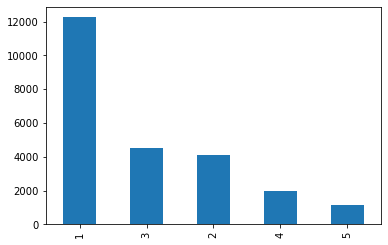

In [466]:
# Class classification
df['PaidTime'].value_counts().plot(kind='bar')
print(df['PaidTime'].value_counts())

In [467]:
# Make a copy of dataframe for future analysis
df_copy = df.copy()

In [468]:
# Remove catagorical features
df.drop([
    "cliente_ocupacion", "pagador_scian_nombre"
], axis=1, inplace=True)

df.head()

,factura_importe,linea_limite,cliente_regimen_fiscal,cliente_sector,cliente_edad,payment_term,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate,RatioSumAmountInvoicesPaidLate,AvgDaysLateInvoicesPaidLate,NumberTotalOutstandingInvoices,NumberOutstandingLateInvoices,RatioOutstandingLateInvoices,SumAmountTotalOutstandingInvoices,SumAmountOutstandingLateInvoices,RatioSumAmountOutstandingLateInvoice,AvgDaysLateOutstandingInvoicesBeingLate,PaidTime
0,6905230.58,20000000.0,0,0,60.0,140.0,49,1,0.020408,31836238.82,137688.20,0.004325,6 days 00:00:00,0,0,0.0,0.0,0.0,0.0,0,1
1,5486110.96,375000.0,0,0,11.0,64.0,0,0,0.000000,0.00,0.00,0.000000,0,0,0,0.0,0.0,0.0,0.0,0,1
2,5464161.79,20000000.0,0,0,60.0,147.0,0,0,0.000000,0.00,0.00,0.000000,0,0,0,0.0,0.0,0.0,0.0,0,1
3,5286577.84,9000000.0,0,0,10.0,29.0,13,4,0.307692,24832580.74,6848070.24,0.275770,4 days 12:00:00,0,0,0.0,0.0,0.0,0.0,0,1
4,5198617.84,20000000.0,0,0,60.0,186.0,43,1,0.023256,17600606.68,137688.20,0.007823,6 days 00:00:00,8,0,0.0,4078948.6,0.0,0.0,0,1


# Output dataset

In [474]:
# Save dataset into S3 bucket
s3_res = boto3.Session().resource('s3')
csv_buffer = StringIO()

df.to_csv(csv_buffer, index=False)

s3_res.Object(bucket_name, 'data/all.csv').put(Body=csv_buffer.getvalue())

print("Dataframe is saved as CSV in S3 bucket.")

Dataframe is saved as CSV in S3 bucket.
